Companion notebook for the paper "MacKay-type visual illusions via neural fieldsi" by Cyprien Tamekue, Dario Prandi, and Yacine Chitour.

# Retino-cortical map

We need to define the retino-cortical map that maps retinal coordinates to the primary visual cortex V1 (see Tamekue et al. (2022) and references therein).

## Point types

We start by defining the type of points we will use. 

In [1]:
# Standard cartesian coordinates in the retinal plane
struct CartesianPoint{T<:Real}
    x::T
    y::T
end

CartesianPoint(x::Real, y::Real) = CartesianPoint(promote(x,y)...)

x(p::CartesianPoint) = p.x
y(p::CartesianPoint) = p.y

y (generic function with 1 method)

Coordinates on the visual field (or in the retina) are polar coordinates $(r,\theta)\in[0,\infty)\times[0,2\pi)$ from the fovea.

In [2]:
# Polar coordinates in the retinal plane
struct RetinalPoint{T<:Real} 
    r::T
    θ::T
end

RetinalPoint(r::Real, θ::Real) = RetinalPoint(promote(r,θ)...)

r(p::RetinalPoint) = p.r
θ(p::RetinalPoint) = p.θ

# Conversions cartesian <-> polar
Base.convert(::Type{RetinalPoint}, p::CartesianPoint; args...) = 
    RetinalPoint( sqrt( x(p)^2 + y(p)^2 ), atan(y(p), x(p)) )
Base.convert(::Type{CartesianPoint}, p::RetinalPoint; args...) = 
    CartesianPoint( r(p)*cos(θ(p)) , r(p)*sin(θ(p)) )

Coordinates on V1 are standard Cartesian coordinates $(x_1,x_2)\in\mathbb{R}^2$.

In [3]:
# Coordinates in the cortical plane
struct CorticalPoint{T<:Real} 
    x::T
    y::T
end

CorticalPoint(x::Real, y::Real) = CorticalPoint(promote(x,y)...)
x(p::CorticalPoint) = p.x
y(p::CorticalPoint) = p.y

y (generic function with 2 methods)

## Conversion formulas

The retino-cortical map (see, e.g., Tamekue et al. (2022) and references within) is given by 
\begin{equation*}
	r e^{i\theta}  \mapsto (x_1,x_2):=\left( \log r, \theta \right).
\end{equation*}

In [4]:
# retinal to cortical
Base.convert(::Type{CorticalPoint}, p::RetinalPoint; far_from_fovea = false) = 
            far_from_fovea ?  CorticalPoint(log(1+ r(p)) , (r(p)*θ(p))/(1+r(p))) : CorticalPoint(log(r(p)) , θ(p))

# cortical to retinal
function Base.convert(::Type{RetinalPoint}, p::CorticalPoint{T}; far_from_fovea = false) where T<:Real
    if iszero( x(p) )
        return RetinalPoint{T}(0,0)
    end
    r = far_from_fovea ?  exp(x(p))-1 : exp(x(p))
    far_from_fovea ? RetinalPoint( r , y(p)*( 1 + 1/r) ) : RetinalPoint( r , y(p))
end

# cartesian <-> cortical conversions
Base.convert(::Type{CorticalPoint}, p::CartesianPoint; args...) = 
            convert(CorticalPoint, convert(RetinalPoint, p; args...); args...)
Base.convert(::Type{CartesianPoint}, p::CorticalPoint; args...) = 
            convert(CartesianPoint, convert(RetinalPoint, p; args...))

## Converting an image from retinal to cortical and conversely

We will represent an image in the retinal plane as a function in the square $[-10,10]\times [-10,10]$. Let's find out to what part of the cortical plane this square corresponds:

In [5]:
a = zeros(200,200)

mesh(img) = [ CartesianPoint(x,y) for x in range(-10,10, length = size(img, 1)), y in range(-10,10, length = size(img, 2))]

x.(convert.(CorticalPoint, mesh(a))) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a))) |> extrema |> display


# We should adjust the intervals for the inverse map (cort2res)
x.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display
y.(convert.(CorticalPoint, mesh(a), far_from_fovea = true)) |> extrema |> display

(-2.644146141450474, 2.649158683274018)

(-3.136567570258981, 3.136567570258981)

(0.06865442183481746, 2.7174812964321107)

(-2.8514283367165345, 2.8514283367165345)

We then define the functions to convert images from their retinal to their cortical representations.

In [6]:
using Images, ImageShow
using Interpolations

function fovea(img)
    xs = range(-1,1, length = size(img, 1))
    ys = range(-1,1, length = size(img, 2))
    eltype(img)[ xs[i]^2+ys[j]^2 < 1 ? img[i,j] : 1. for i in 1:length(xs), j in 1:length(ys)  ]
end

function res2cort(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
#    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-2.851, 2.851, length = size(img,2))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CartesianPoint, CorticalPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

function cort2res(img; far_from_fovea = false)
    # Linear interpolation of starting image
    xs = far_from_fovea ?  range(0.068, 2.717, length = size(img,1)) : range(-2.644, 2.649, length = size(img,1))
    ys = far_from_fovea ?  range(-2.851, 2.851, length = size(img,2)) : range(-3.136, 3.136, length = size(img,2))
    interp_linear = LinearInterpolation((xs, ys), transpose(convert.(Float64, img)), extrapolation_bc = Line())

    res = similar(img, Gray)
    xs = range(-10,10, length = size(img, 1))
    ys = range(-10,10, length = size(img, 2))
    for i in 1:size(img,2), j in 1:size(img,1)
        p = convert(CorticalPoint, CartesianPoint(xs[i], ys[j]), far_from_fovea = far_from_fovea)
        res[j,i] =  convert(Gray, interp_linear(x(p), y(p)))
    end
    
    res
end

cort2res (generic function with 1 method)

In [7]:
binary(x) = x>0 ? zero(x) : one(x)

binary (generic function with 1 method)

# Finding the stationary state of NF equation

The theory tells us that, given an input $I$, the corresponding stationary state is $\Psi(I)$ that solves the following equation:
$$
\Psi(I)(x) = \mu\int w_2(x,y)f(\Psi(I)(y))\,dy +I(x),\qquad x\in\mathbb R^2.
$$
We then code an iterative procedure (which converges thanks to the fixed point theorem) to derive $\Psi(I)$.

In [8]:
using Parameters

@with_kw struct Model
    ω::Function = (x,y) -> exp(-(x^2+y^2)) - exp(-(x^2+y^2)/2)
    σ::Function = s -> min(1,max(0,s))
    μ::Number = 1.
    
    Δx::Number = .01 # finesse of the discretization
    L::Number = 10   # size of the grid
end

Model

Definition of the convolution operator $K(a) = \omega\ast a$.

In [9]:
using OffsetArrays, ImageFiltering

function K(a, m::Model)
    @unpack Δx, ω, L = m
    As = centered([Δx^2*ω(x,y) for x in -L:Δx:L, y in -L:Δx:L])
    imfilter(a,reflect(As),"reflect")
end

K (generic function with 1 method)

Fixed point routine.

In [10]:
using Distances
function Ψ(I, m::Model; max_iter = 100, threshold = 1e-15)
    @unpack Δx, σ, μ = m
    
    # As first step we take I
    prec = I
    ΨI = I
    # to keep track of final iteration
    final_iter = max_iter
    for i in 1:max_iter
        ΨI = μ*K(σ.(ΨI), m) + I
        evaluate(Chebyshev(), prec, ΨI)
        if Chebyshev()(prec, ΨI) <= threshold
            final_iter = i
        break
        else
            prec = ΨI
        end
    end
    println("Extrema of I: ", extrema(I), ", extrema of ΨI: ", extrema(ΨI))
    A_1 = binary.(I) |> rotl90 |> cort2res
    B_1 = binary.(ΨI) |> rotl90 |> cort2res    
    hcat(A_1, ones(Gray, (size(A_1,1),50)), B_1)
end

Ψ (generic function with 1 method)

# Reproducing the MacKay effect

In [11]:
#################
# MacKay effect #
#################

MacKay = Model(
            ω = (x,y)->π*exp(-π^2*(x^2+y^2))-π*exp(-π^2*(x^2+y^2)/2)/2,
            μ = 1.)

Model
  ω: #25 (function of type var"#25#26")
  σ: #15 (function of type var"#15#21")
  μ: Float64 1.0
  Δx: Float64 0.01
  L: Int64 10


## Patterns

We define two helper functions to generate the cortical patterns we are interested in.

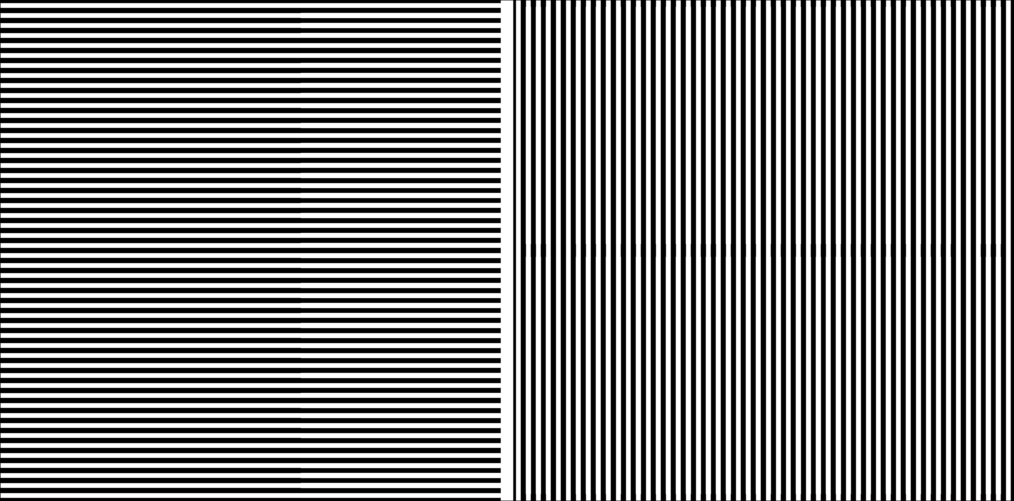

In [12]:
function funnel(m::Model; λ = 5π, max_inner = 0.025)
    @unpack L, Δx = m
        
    f(x,y)   = cos(λ*y)
    χ(x,y)   = (-L ≤ x ≤ 2) && (-L ≤ y ≤ L) ? max_inner : 0.
    
    [ f(x,y) + χ(x,y) for x in -L:Δx:L, y in -L:Δx:L]
end

function tunnel(m::Model; λ = 5π, max_inner = 0.025)
    @unpack L, Δx = m
        
    f(x,y)   = cos(λ*x)
    χ(x,y) = (-L ≤ x ≤ L) && ((-.25 ≤ y ≤ .25) || (9.75 ≤ y ≤ L) || (-L ≤ y ≤ -9.75)) ? max_inner : 0.
    
    [ f(x,y) + χ(x,y) for x in -L:Δx:L, y in -L:Δx:L]
end

A = funnel(MacKay) |> rotl90
B = tunnel(MacKay) |> rotl90
hcat(Gray.(binary.(A)), ones(Gray, (size(A,1),50)), Gray.(binary.(B)))

And their retinal representations.

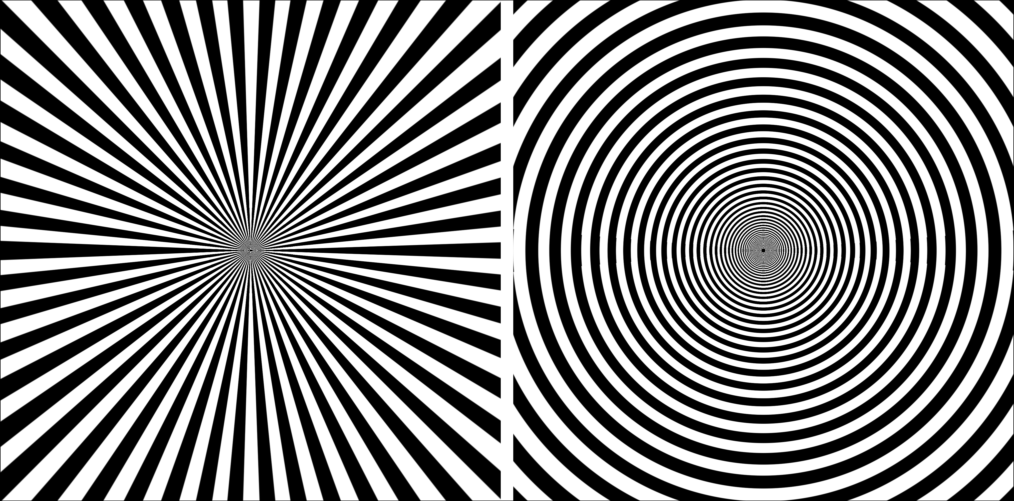

In [13]:
A1 = cort2res(binary.(A))
B1 = cort2res(binary.(B))
hcat(A1, ones(Gray, (size(A1,1),50)), B1)

## MacKay effect with linear response function

Here, we show that the MacKay effect can be reproduced with a linear response function $\sigma(s)=s$.

In the left we have the external input in the retina and on the right the illusory after-image perceived.

In [14]:
linear_mackay = Model(MacKay; σ = s -> s)

Model
  ω: #25 (function of type var"#25#26")
  σ: #37 (function of type var"#37#38")
  μ: Float64 1.0
  Δx: Float64 0.01
  L: Int64 10


Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0045169211309306, 1.0295169211309307)
 39.091319 seconds (14.91 M allocations: 30.656 GiB, 4.59% gc time, 4.51% compilation time)


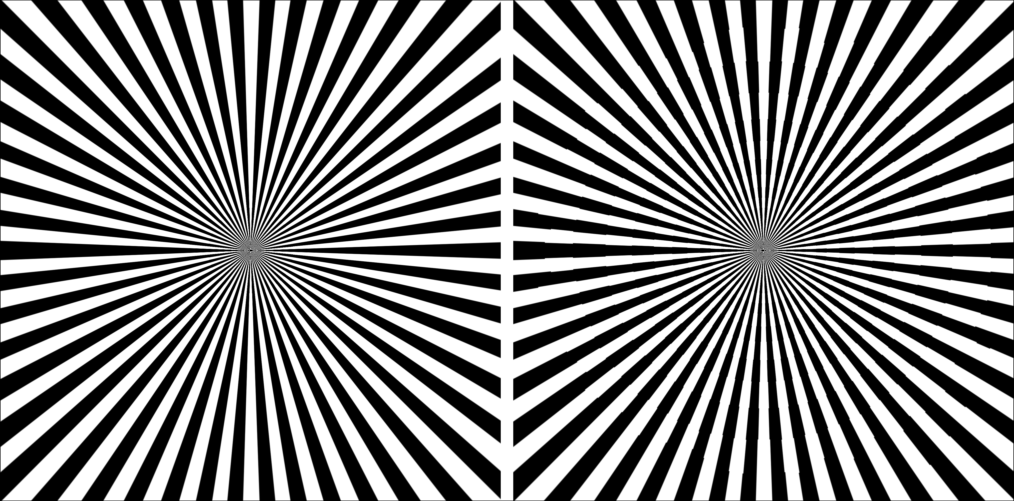

In [15]:
# MacKay effect for funnel pattern (``MacKay rays'')
@time Ψ(funnel(MacKay), linear_mackay)

Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0044904805848462, 1.032091186274359)


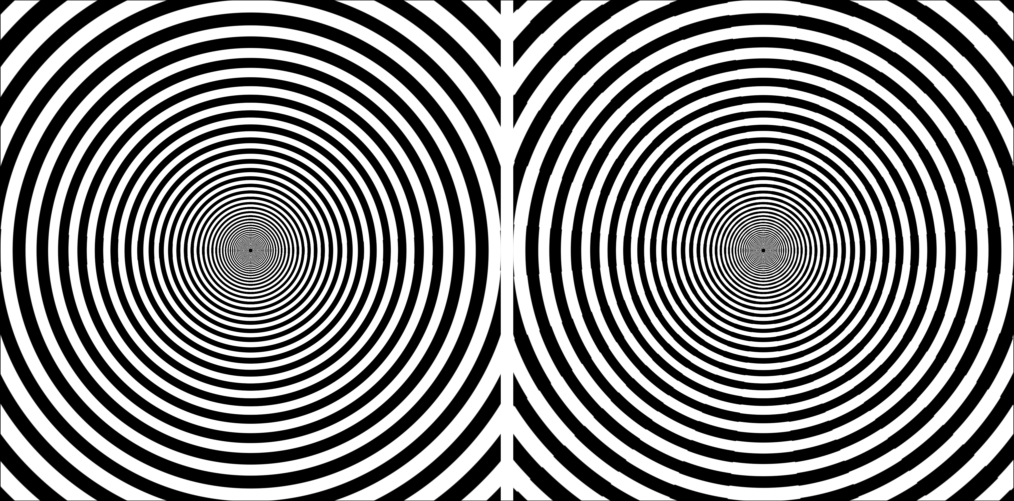

In [16]:
# MacKay effect for tunnel pattern (``target pattern'')
Ψ(tunnel(MacKay), linear_mackay)

## MacKay effect with nonlinear response function

With a nonlinear response function which is sigmoidal and odd, the equation reproduces the MacKay effect. Namely, we consider the choices
$$
\sigma(s) = \frac{s}{1+|s|} \quad\text{and}\quad \sigma(s) = \tanh(s).
$$

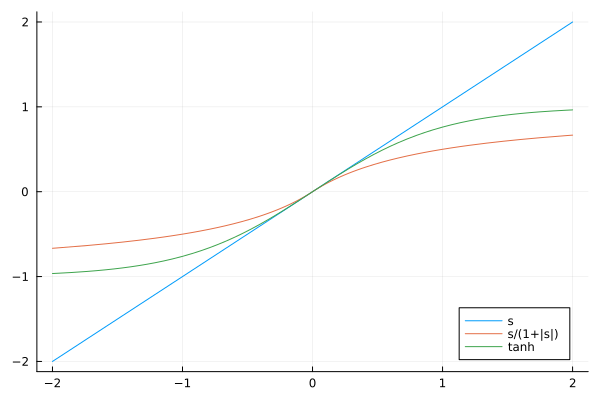

In [17]:
using Plots

# PNG images for plots (to save them in the notebook)
Plots.default(fmt=:png)

plot([s->s, s->s/(1+abs(s)), tanh], -2,2, labels = ["s" "s/(1+|s|)" "tanh"], legend = :bottomright)

In the left we have the external input in the retina and on the right the illusory after-image perceived.

Extrema of I: (-1.0, 1.1), extrema of ΨI: (-1.0048920402214672, 1.1048872309462985)


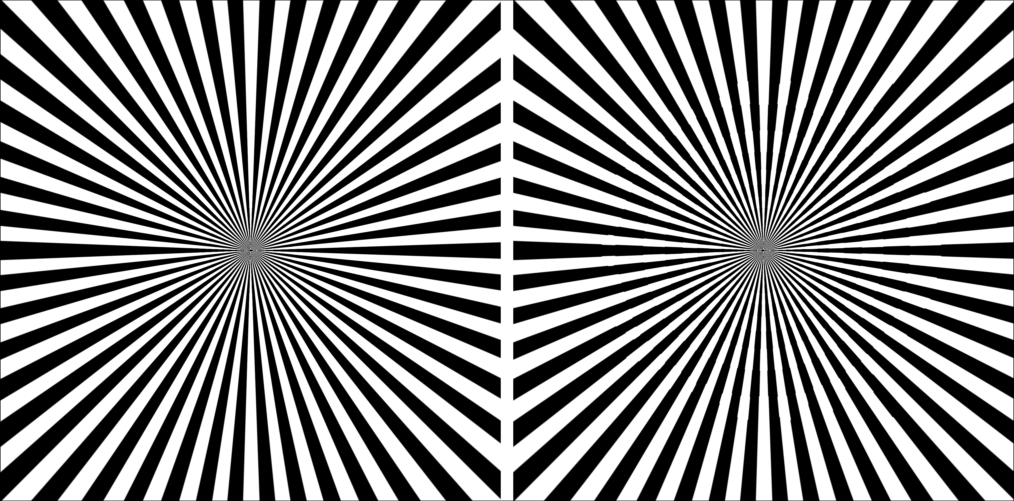

In [18]:
# The MacKay effect for funnel pattern (``target pattern'')

#the response function is nonlinear
nonlinear_mackay = Model(MacKay; σ = s -> s/(1+abs(s)))

Ψ(funnel(MacKay, max_inner = 0.1), nonlinear_mackay)

Extrema of I: (-1.0, 1.025), extrema of ΨI: (-1.0031058755034996, 1.0297520365541704)


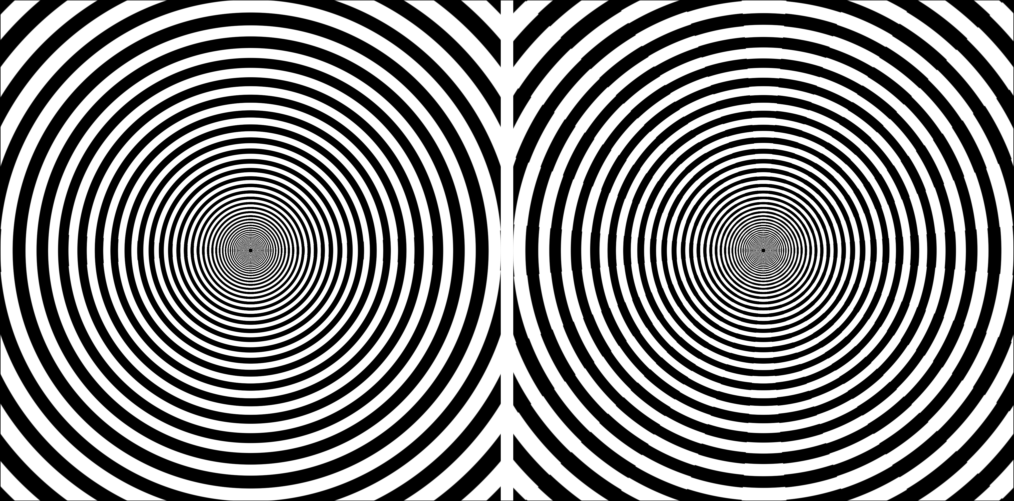

In [19]:
# The MacKay effect for tunnel pattern (``target pattern'')

#the response function is nonlinear
tanh_mackay = Model(MacKay; σ = tanh)

Ψ(tunnel(MacKay), tanh_mackay)

# Reproducing Billock and Tsou's phenomena

In [20]:
##################################
# Billock and Tsou's experiments #
##################################


const σ1      = 0.1
const σ2      = 0.5
const κ        = (σ1/σ2)^2*exp(2*pi^2*(σ2^2-σ1^2))
const Θ        = σ1*σ2*sqrt(2*log(σ2^2/(κ*σ1^2))/(σ2^2-σ1^2))
const C      = (1-κ)+2*(κ*exp(-0.5*Θ^2/σ2^2)-exp(-0.5*Θ^2/σ1^2))         

BillockTsou = Model(
            ω = (x,y) -> (1/(2π*σ1^2))*exp(-(x^2+y^2)/(2*σ1^2))-κ*(1/(2π*σ2^2))*exp(-(x^2+y^2)/(2*σ2^2)),
            μ = 0.99/C)

Model
  ω: #45 (function of type var"#45#46")
  σ: #15 (function of type var"#15#21")
  μ: Float64 0.21518283891839976
  Δx: Float64 0.01
  L: Int64 10


## Patterns

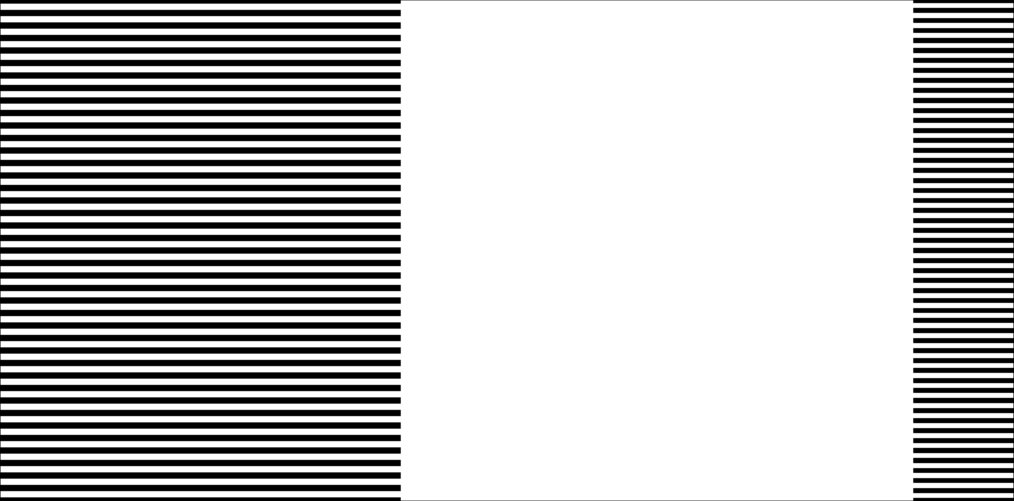

In [21]:
function funnel_fovea(m::Model; λ = 4π, max_inner = 0.025)
    @unpack L, Δx = m
        
    f(x,y)   = cos(λ*y)
    χ(x,y)   = (-L ≤ x ≤ 6) && (-L ≤ y ≤ L) ? 1 : 0.    #localised function

    [ f(x,y) * χ(x,y) for x in -L:Δx:L, y in -L:Δx:L]
end

function funnel_periphery(m::Model; λ = 5π, max_inner = 0.025)
    @unpack L, Δx = m
        
    f(x,y)   = cos(λ*y)
    χ(x,y)   = (6 ≤ x ≤ L) && (-L ≤ y ≤ L) ? 1 : 0.        #localised function  
    
    [ f(x,y) * χ(x,y) for x in -L:Δx:L, y in -L:Δx:L]
end

A = funnel_fovea(BillockTsou) |> rotl90
B = funnel_periphery(BillockTsou) |> rotl90
hcat(Gray.(binary.(A)), ones(Gray, (size(A,1),50)), Gray.(binary.(B)))

And their retinal representations.

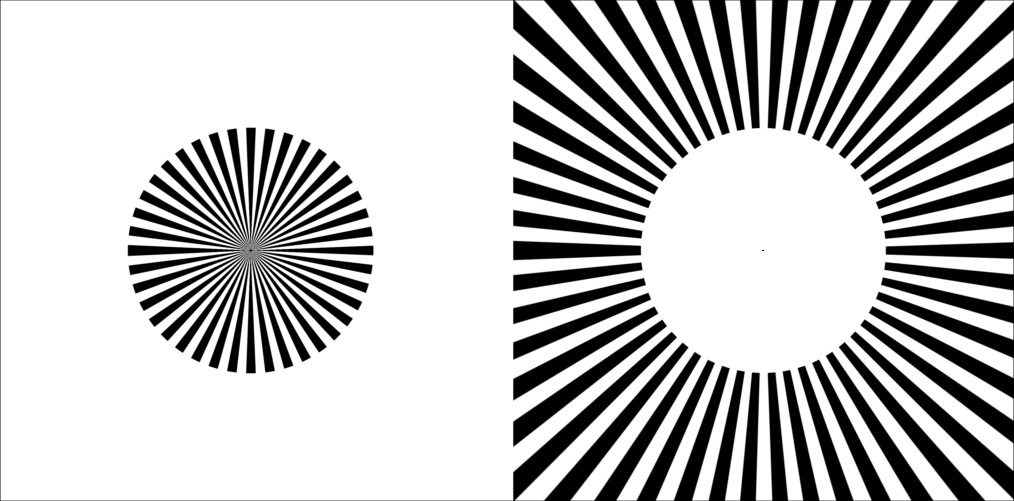

In [22]:
A1 = cort2res(binary.(A))
B1 = cort2res(binary.(B))
hcat(A1, ones(Gray, (size(A1,1),50)), B1)

## Response function
For Billok and Tsou's phenomenon we consider the family of response functions
$$\sigma(s) = \max(-m, \min(1, \alpha*s)).$$

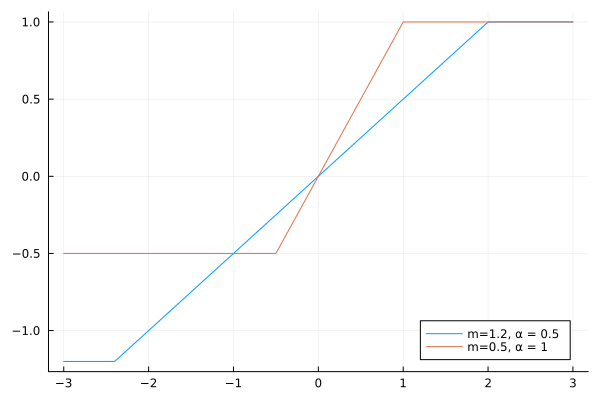

In [23]:
using Plots
Σ(; m = 1, α = 1) = s -> max( -m, min( 1, α*s) )

plot([ s->Σ(m= 1.2, α = .5)(s), s->Σ(m= .5, α = 1)(s) ], -3, 3, 
    labels = [ "m=1.2, α = 0.5" "m=0.5, α = 1"], legend = :bottomright )

In the left we have the external input in the retina and on the right the illusory after-image perceived.

Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.2172661417138708, 0.9933121217784716)


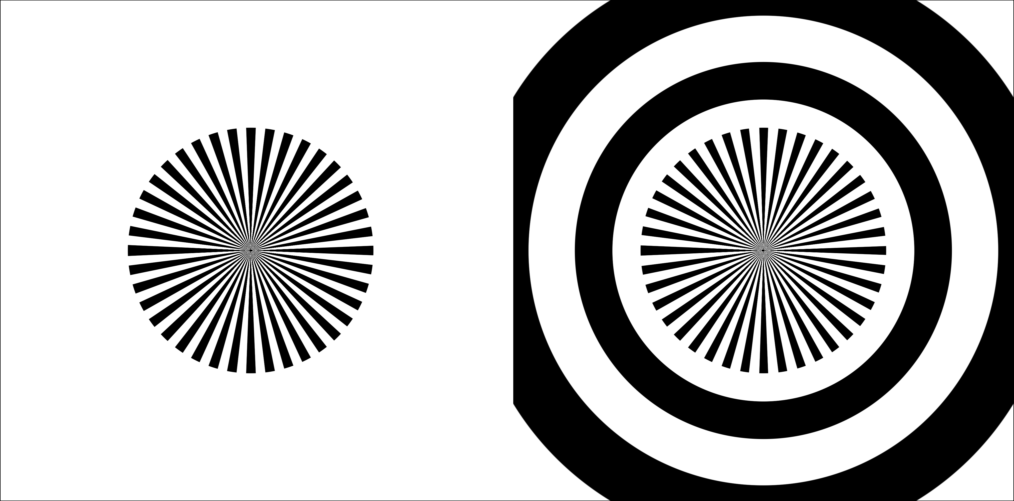

In [24]:
# Billock and Tsou's experiments for funnel pattern localised at the fovea

# response function (m = 0.2, α = 1.2)
fovea1_BT = Model(BillockTsou; σ = Σ(m=0.2, α = 1.2))

Ψ(funnel_fovea(BillockTsou), fovea1_BT, threshold = 1e-11)

Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.1033525614458126, 1.1105164315311402)


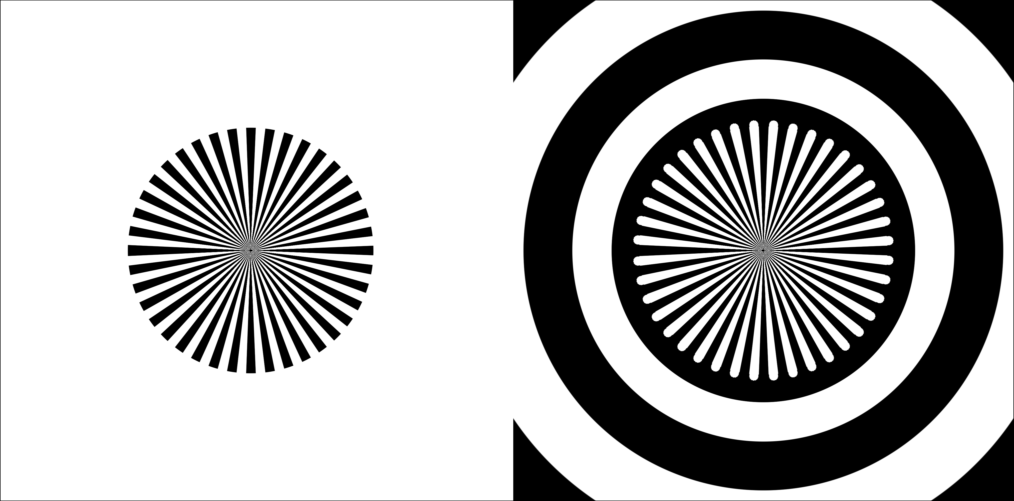

In [25]:
# response function (m = 1.2, α = 1)
fovea2_BT = Model(BillockTsou; σ = Σ(m=1.2, α = 1.))

Ψ(funnel_fovea(BillockTsou), fovea2_BT, threshold = 1e-11)

Extrema of I: (-1.0, 1.0), extrema of ΨI: (-1.1278140791587594, 0.984362151277791)


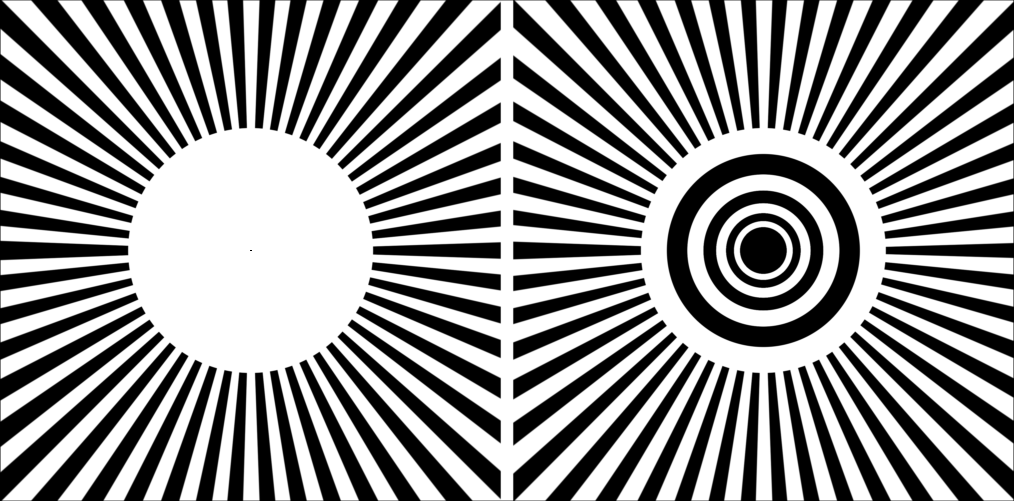

In [26]:
# Billock and Tsou's experiments for funnel pattern localised in the periphery

# response function (m = 0.2, α = 0.8)
periphery_BT = Model(BillockTsou; σ = Σ(m=0.2, α = 0.8))

Ψ(funnel_periphery(BillockTsou), periphery_BT, threshold = 1e-11)

## Relation between response function parameters and reproducibility of Billock and Tsou phenomena

A theorem provided in the theoretical work tells us that phenomena reported by Billock and Tsou are wholly nonlinear. It means, the NF equation with a linear response function $\sigma$ do not reproduce the phenomena. 

As before, we take 
$$\sigma(s) = \max(-m, \min(1, \alpha*s)),\qquad s\in\mathbb R,$$
where $m\ge 0$ and $\alpha>0$. We then provide a range of parameters $(m, \alpha)$ where the sigmoid $f$ reproduces the phenomena or not:

1) In the region in <i> magenta </i> the couple $(m,\alpha)$ reproduces the phenomenon;

2) In the region in <i> yellow </i> the couple $(m,\alpha)$ reproduces the phenomenon and the stimulus extends through the surround;

3) In the region in <i> black </i>, the couple $(m,\alpha)$ does not reproduce the phenomenon.

To code these results, we have to slightly modify the output of the procedure $\Psi(I, ...)$, which give the stationary state associated with an input $I$. Indeed, we only need the matrix form of the stationary state.

In [27]:
using Distances

function Ψ(I, m::Model; max_iter = 100, threshold = 1e-15)
    @unpack Δx, σ, μ = m
    
    # As first step we take I
    prec = I
    ΨI = I
    # to keep track of final iteration
    final_iter = max_iter
    for i in 1:max_iter
        ΨI = μ*K(σ.(ΨI), m) + I
        evaluate(Chebyshev(), prec, ΨI)
        if Chebyshev()(prec, ΨI) <= threshold
            final_iter = i
        break
        else
            prec = ΨI
        end
    end
    binary.(ΨI) |> rotl90
end

Ψ (generic function with 1 method)

In [28]:
using ProgressMeter

function BT_reproduction(I, ms, ns, m::Model; max_iter = 100, threshold = 1e-11, verbose = false)    
    S      = zeros(Int,length(ms), length(ns))     # Storage matrix

    @showprogress for k in 1:(length(ms) * length(ns))
        i, j = fldmod1(k, length(ns))

        cur_model = Model(m; σ = Σ(m = ms[i], α = ns[j]))
        
        mat         = Ψ(I, cur_model,threshold = threshold);
        a1          = mat[1:size(mat,1),1602:size(mat,2)]
        if (a1 == zeros(size(a1)...)) || (a1 == ones(size(a1)...))
            S[i,j] = 0
            verbose && println("(", ms[i], ";", ns[j], ") does not reproduce the phenomenon")
        else
            compteur = 0
            for l in 1:size(a1,2)-1
                if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
                    compteur += 1
                else
                    break
                end
                # compteur = compteur
            end
            verbose && println("compteur = ", compteur)
            for l in compteur+1:size(a1,2)
                if (a1[:,l] != zeros(size(a1,1))) && (a1[:,l] != ones(size(a1,1)))
                    S[i,j] = 0
                    verbose && println("(", ms[i], ";", ns[j], ") does not reproduce the phenomenon")
                    break
                elseif (l+1 ≤ size(a1,2))
                    continue
                else
                    for k in compteur+1:size(a1,2)-1
                        if (a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k))
                            S[i,j] = 0
                            verbose && println("(", ms[i], ";", ns[j], ") does not reproduce the phenomenon")
                            break       
                        elseif (a1[:,k] != a1[:,k+1]) && ((a1[:,k+1:size(a1,2)] == ones(size(a1,1),size(a1,2)-k)) || (a1[:,k+1:size(a1,2)] == zeros(size(a1,1),size(a1,2)-k)))
                            S[i,j] = 0
                            verbose && println("(", ms[i], ";", ns[j], ") does not reproduce the phenomenon")
                            break
                        elseif (compteur == 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))
                            S[i,j] = 1
                            verbose && println("(", ms[i], ";", ns[j], ") reproduces the phenomenon")
                            break
                        elseif (compteur != 0) && (a1[:,k] != a1[:,k+1]) && (a1[:,k+1:size(a1,2)] != ones(size(a1,1),size(a1,2)-k)) && (a1[:,k+1:size(a1,2)] != zeros(size(a1,1),size(a1,2)-k))   
                            S[i,j] = 2
                            verbose && println("(", ms[i], ";", ns[j], ") reproduces the phenomenon but the stimulus extends through the complementary region")
                            break
                        end
                    end
                end
            end
        end
    end
    
    S
end


BT_reproduction (generic function with 1 method)

In [29]:
ms        = 0.:0.1:2.                                    # range for minimal bound of σ
ns        = 0.1:0.1:2.                                   # range for slop of σ

S = BT_reproduction(funnel_fovea(BillockTsou), ms, ns, BillockTsou)

Progress: 100%|█████████████████████████████████████████| Time: 11:18:40


21×20 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 2  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
 0  2  2  2  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
 0  0  2  2  2  2  1  1  1  1  1  1  0  0  0  0  0  0  0  0
 0  0  0  2  2  2  2  2  2  1  1  1  0  0  0  0  0  0  0  0
 0  0  0  0  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  2  2  2  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  2  2  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  2  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  2  2  2  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  2  2  2  2  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  2  2  2  2  0  0  0  0  0  0  0
 0  0  0  0  0  0  

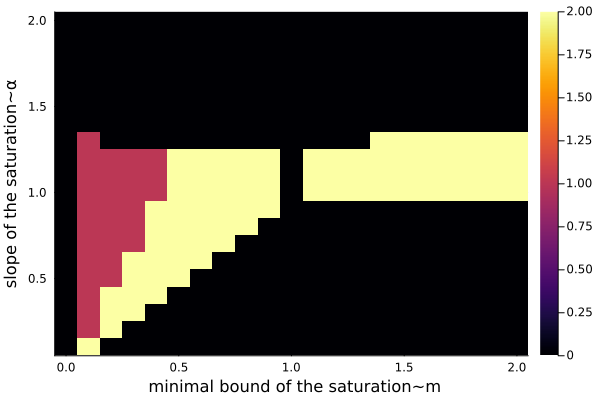

In [30]:
using Plots
p = Plots.plot(Plots.heatmap(ms, ns, S', hoverongaps=false), xlabel = " minimal bound of the saturation~m", ylabel = "slope of the saturation~α")

#### heatmap without a color bar

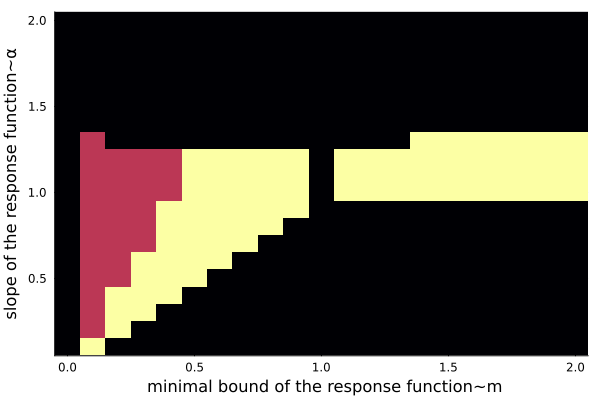

In [31]:
p = Plots.plot(Plots.heatmap(ms, ns, S', hoverongaps=false, legend = :none), xlabel = " minimal bound of the response function~m", ylabel = "slope of the response function~α")